<a href="https://colab.research.google.com/github/sanjanb/Natural_Language_Processing/blob/main/Sarcastm_Analysis_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing LSTMs using TensorFlow

This notebook contains the implementation of an LSTM model to classify news headlines as sarcastic or not_sarcastic. We will analyse the accuracy & loss curves for training and validation sets.

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## Downloading the Headlines data


In [3]:
from google.colab import files
uploaded = files.upload()


Saving Sarcasm_Headlines_Dataset.json to Sarcasm_Headlines_Dataset.json


In [4]:
import pandas as pd
import json

# Read the file as a string
with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
    data_str = f.read()

# Replace new lines with commas and wrap in brackets to create a valid JSON list
data_str = "[" + data_str.replace("}\n{", "},{") + "]"

# Parse the JSON list
data = pd.read_json(data_str)

data.head()

<ipython-input-4-7577d2140fac>:12: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_json(data_str)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
# Create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

## Data Preparation

In [6]:
# Data Preparation
vocab_size = 10000  # Define vocabulary size
max_length = 100  # Define maximum sequence length
embedding_dim = 100  # Define embedding dimension
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = int(len(headlines) * 0.8)  # 80% for training



In [7]:
# Training set from 0 to training size
training_sentences = headlines[:training_size]
training_labels = labels[:training_size]

# Testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

# Tokenize the training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert lists to numpy arrays
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)




## Define the LSTM model with the following layers:
1. Embedding layer
2. Add two bidirectional LSTM layers with 64 and 32 as number of outputs.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation

In [8]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model with an input shape
model.build(input_shape=(None, max_length))

# Show model summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,281 (4.30 MB)

 Trainable params: 1,127,281 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

## Tain and Visualize accuracy and loss

Epoch 1/10
668/668 - 19s - 29ms/step - accuracy: 0.8205 - loss: 0.3817 - val_accuracy: 0.8579 - val_loss: 0.3210
Epoch 2/10
668/668 - 17s - 26ms/step - accuracy: 0.9234 - loss: 0.1912 - val_accuracy: 0.8605 - val_loss: 0.3391
Epoch 3/10
668/668 - 20s - 31ms/step - accuracy: 0.9623 - loss: 0.1032 - val_accuracy: 0.8517 - val_loss: 0.4787
Epoch 4/10
668/668 - 12s - 18ms/step - accuracy: 0.9799 - loss: 0.0567 - val_accuracy: 0.8461 - val_loss: 0.5572
Epoch 5/10
668/668 - 21s - 31ms/step - accuracy: 0.9874 - loss: 0.0377 - val_accuracy: 0.8418 - val_loss: 0.6636
Epoch 6/10
668/668 - 21s - 31ms/step - accuracy: 0.9927 - loss: 0.0223 - val_accuracy: 0.8377 - val_loss: 0.7656
Epoch 7/10
668/668 - 20s - 31ms/step - accuracy: 0.9939 - loss: 0.0176 - val_accuracy: 0.8441 - val_loss: 0.8057
Epoch 8/10
668/668 - 20s - 31ms/step - accuracy: 0.9950 - loss: 0.0147 - val_accuracy: 0.8373 - val_loss: 0.8559
Epoch 9/10
668/668 - 12s - 18ms/step - accuracy: 0.9958 - loss: 0.0130 - val_accuracy: 0.8360 - 

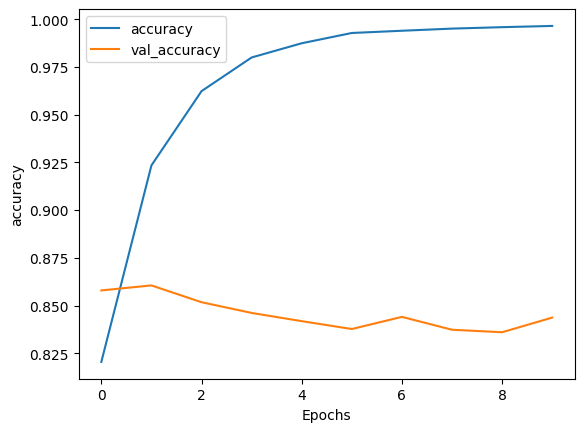

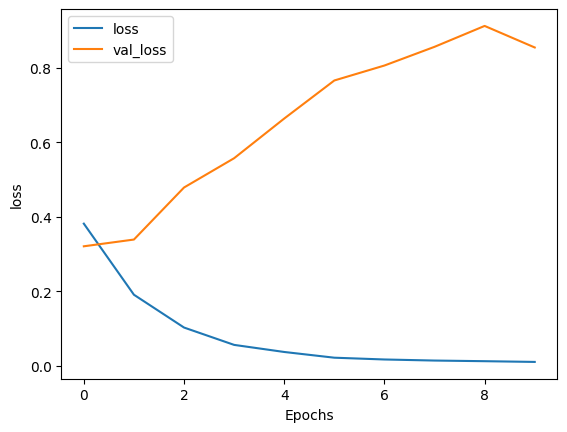

In [9]:
# Train the model
num_epochs = 10
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    verbose=2
)

# Visualize accuracy and loss
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_metrics(history, "accuracy")
plot_metrics(history, "loss")



In [13]:
print(history.history['accuracy'][-1])  # Last training accuracy
print(history.history['val_accuracy'][-1])  # Last validation accuracy


0.9964430928230286
0.8436915278434753


## Classifying unseen headlines

In [16]:
# Classifying unseen headlines
sentence = [
    "Oh great, another meeting!",
    "The sun is shining and the weather is nice."
]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Print model predictions
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[9.8967361e-01]
 [1.3783504e-05]]


In [18]:
# easier to read
predictions = model.predict(padded)

for i, sentence in enumerate(sentence):
    sarcasm_score = predictions[i][0]
    label = "Sarcastic" if sarcasm_score > 0.5 else "Not Sarcastic"
    print(f"Sentence: \"{sentence}\"\nPrediction: {label} ({sarcasm_score:.2%} confidence)\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sentence: "Oh great, another meeting!"
Prediction: Sarcastic (98.97% confidence)

Sentence: "The sun is shining and the weather is nice."
Prediction: Not Sarcastic (0.00% confidence)

